20:49:57 - cmdstanpy - INFO - Chain [1] start processing
20:49:57 - cmdstanpy - INFO - Chain [1] done processing


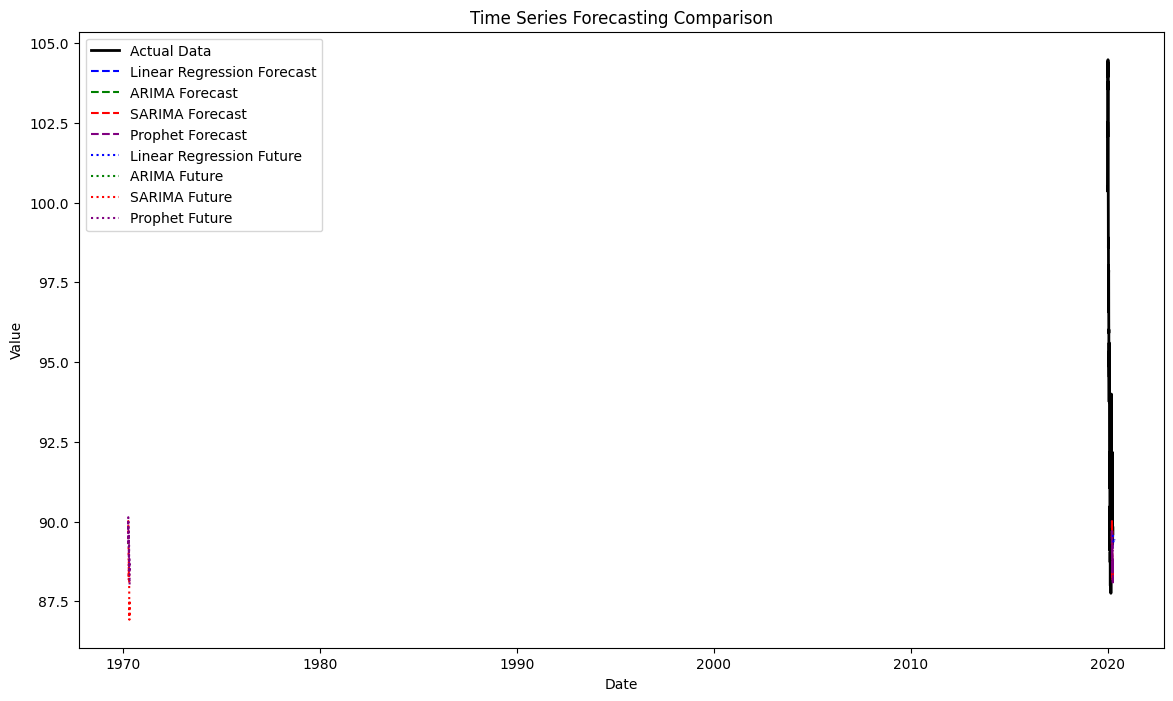

Linear Regression - MAE: 89.5662, RMSE: 89.5687
ARIMA - MAE: 1.2489, RMSE: 1.4623
SARIMA - MAE: 1.5646, RMSE: 1.8443
Prophet - MAE: 1.7718, RMSE: 1.9636


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# データの準備
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', periods=100, freq='D')
data = np.cumsum(np.random.randn(100)) + 100  # ランダムウォーク
df = pd.DataFrame({'ds': date_range, 'y': data})

# 線形回帰で1階差を予測
def linear_regression_forecast(df, future_steps):
    df['diff'] = df['y'].diff().fillna(0)
    df['day'] = np.arange(len(df))
    
    X = df[['day']]
    y = df['diff']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # 予測値を累積して元のスケールに戻す
    y_pred_diff = model_lr.predict(X_test)
    y_pred = np.cumsum(y_pred_diff) + df['y'].iloc[len(X_train)-1]
    
    # 将来の予測
    future_preds = []
    last_value = df['y'].iloc[-1]
    
    for i in range(future_steps):
        # `next_day`に列名を付けてモデルに入力
        next_day = pd.DataFrame([[len(df) + i]], columns=['day'])
        next_diff = model_lr.predict(next_day)
        last_value += next_diff[0]
        future_preds.append(last_value)
    
    future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)
    
    return y_test, y_pred, df['ds'].iloc[-len(y_pred):], future_dates, future_preds

# ARIMAでの予測
def arima_forecast(df, future_steps):
    model_arima = ARIMA(df['y'], order=(5,1,0))
    arima_result = model_arima.fit()
    
    forecast_arima = arima_result.forecast(steps=len(df) // 5)
    future_forecast_arima = arima_result.forecast(steps=future_steps)
    return df['y'].iloc[-len(forecast_arima):], forecast_arima, future_forecast_arima

# SARIMAでの予測
def sarima_forecast(df, future_steps):
    sarima_model = SARIMAX(df['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_result = sarima_model.fit()
    
    forecast_sarima = sarima_result.get_forecast(steps=len(df) // 5).predicted_mean
    future_forecast_sarima = sarima_result.get_forecast(steps=future_steps).predicted_mean
    return df['y'].iloc[-len(forecast_sarima):], forecast_sarima, future_forecast_sarima

# Prophetでの予測
def prophet_forecast(df, future_steps):
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=future_steps)
    forecast = model.predict(future)
    
    forecast_prophet = forecast['yhat'].iloc[-len(df) // 5:]
    future_forecast_prophet = forecast['yhat'].iloc[-future_steps:]
    return df['y'].iloc[-len(forecast_prophet):], forecast_prophet, future_forecast_prophet

# 可視化と誤差計算
def visualize_and_calculate_errors(df, future_steps):
    # 各モデルの予測を取得
    y_test_lr, y_pred_lr, dates_lr, future_dates_lr, future_preds_lr = linear_regression_forecast(df, future_steps)
    y_test_arima, y_pred_arima, future_preds_arima = arima_forecast(df, future_steps)
    y_test_sarima, y_pred_sarima, future_preds_sarima = sarima_forecast(df, future_steps)
    y_test_prophet, y_pred_prophet, future_preds_prophet = prophet_forecast(df, future_steps)
    
    # グラフの作成
    plt.figure(figsize=(14, 8))
    
    # 過去のデータと予測値をプロット
    plt.plot(df['ds'], df['y'], label='Actual Data', color='black', linewidth=2)
    plt.plot(dates_lr, y_pred_lr, label='Linear Regression Forecast', color='blue', linestyle='--')
    plt.plot(df['ds'].iloc[-len(y_pred_arima):], y_pred_arima, label='ARIMA Forecast', color='green', linestyle='--')
    plt.plot(df['ds'].iloc[-len(y_pred_sarima):], y_pred_sarima, label='SARIMA Forecast', color='red', linestyle='--')
    plt.plot(df['ds'].iloc[-len(y_pred_prophet):], y_pred_prophet, label='Prophet Forecast', color='purple', linestyle='--')
    
    # 将来予測をプロット
    plt.plot(future_dates_lr, future_preds_lr, label='Linear Regression Future', color='blue', linestyle=':')
    plt.plot(future_preds_arima.index, future_preds_arima, label='ARIMA Future', color='green', linestyle=':')
    plt.plot(future_preds_sarima.index, future_preds_sarima, label='SARIMA Future', color='red', linestyle=':')
    plt.plot(future_preds_prophet.index, future_preds_prophet, label='Prophet Future', color='purple', linestyle=':')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Forecasting Comparison')
    plt.legend()
    plt.show()
    
    # 誤差の計算
    mae_lr = mean_absolute_error(y_test_lr, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
    
    mae_arima = mean_absolute_error(y_test_arima, y_pred_arima)
    rmse_arima = np.sqrt(mean_squared_error(y_test_arima, y_pred_arima))
    
    mae_sarima = mean_absolute_error(y_test_sarima, y_pred_sarima)
    rmse_sarima = np.sqrt(mean_squared_error(y_test_sarima, y_pred_sarima))
    
    mae_prophet = mean_absolute_error(y_test_prophet, y_pred_prophet)
    rmse_prophet = np.sqrt(mean_squared_error(y_test_prophet, y_pred_prophet))
    
    # 結果を表示
    print("Linear Regression - MAE: {:.4f}, RMSE: {:.4f}".format(mae_lr, rmse_lr))
    print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}".format(mae_arima, rmse_arima))
    print("SARIMA - MAE: {:.4f}, RMSE: {:.4f}".format(mae_sarima, rmse_sarima))
    print("Prophet - MAE: {:.4f}, RMSE: {:.4f}".format(mae_prophet, rmse_prophet))

# 可視化と誤差の計算を実行
future_steps = 30
visualize_and_calculate_errors(df, future_steps)
